# Final Validation of the selected model

Here the final validation and visualization of the selected model is performed.

### Importing the standard libraries

In [99]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the dataset

In [100]:
dataset = pd.read_csv('../assets/car-details-for-ml.csv')

dataset.head()

,year,km_driven,fuel,transmission,seller_type,owner,seats,mileage,engine,max_power,...,Mitsubishi,Nissan,Opel,Renault,Skoda,Tata,Toyota,Volkswagen,Volvo,selling_price
0,2014,145500,0,0,1,0,5.0,23.40,1248,74.00,...,0,0,0,0,0,0,0,0,0,450000
1,2014,120000,0,0,1,2,5.0,21.14,1498,103.52,...,0,0,0,0,1,0,0,0,0,370000
2,2006,140000,1,0,1,3,5.0,17.70,1497,78.00,...,0,0,0,0,0,0,0,0,0,158000
3,2010,127000,0,0,1,0,5.0,23.00,1396,90.00,...,0,0,0,0,0,0,0,0,0,225000
4,2007,120000,1,0,1,0,5.0,16.10,1298,88.20,...,0,0,0,0,0,0,0,0,0,130000


### Splitting the dataset into the Training and Test set

In [101]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=73)

### Helper methods for the model

In [103]:
# Plots n predictions and actual values against each other
import random

def plot_results_graph(model: str, y_test, y_pred, start: int = 0, end: int = 200):
    color = (random.random(), random.random(), 0)

    plt.figure(figsize=(20, 8))
    plt.plot(y_test[start:end], color="b")
    plt.plot(y_pred[start:end], '--', color=color,)
    plt.title(model)
    plt.ylabel('Price')
    plt.legend(['Actual value','Predicted value'])
    plt.show()

In [104]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score

# R2 (R-squared) score = Statistical measure of how close the predicted data are to the actual data.
# Mean Absolute Error (MAE) = The mean value of all errors, positive and negative (absolute value)
# Root Mean Squared Error (RMSE) = The errors are squared and then the mean value is found. The root of the calculated mean value is taken.

labels = ['Model', 'R2', 'MAE', 'RMSE', 'R2 CV Mean']
results = []

def model_evaluation(model: str, regressor, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)

    cv = cross_val_score(regressor, X_train, y_train, cv=10, scoring='r2')

    results.append([model, r2, mae, rmse, cv.mean()])
    return [model, r2, mae, rmse, cv.mean()]

# The Random Forest Model

The Random Forest Model performed the best in the model selection process. This model is used for the final validation.

In [105]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=73)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=73)

In [106]:
y_pred = forest_reg.predict(X_test)

np.set_printoptions(precision=2)
actual_vs_pred = np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1)

print(["Actual", "Predictions"])
print(actual_vs_pred[:8])

['Actual', 'Predictions']
[[3400000.   3523600.  ]
 [ 950000.   1078759.99]
 [ 934000.    776176.18]
 [ 450000.    438850.  ]
 [ 350000.    428389.98]
 [ 140000.    195979.99]
 [1125000.   1161620.  ]
 [ 316000.    275261.67]]


In [107]:
forest_reg_result = model_evaluation('Random Forest Regression', forest_reg, y_test, y_pred)

for i in range(len(forest_reg_result)):
    print(labels[i], ':', forest_reg_result[i])

Model : Random Forest Regression
R2 : 0.968150075757641
MAE : 62365.82973007254
RMSE : 105968.34395664117
R2 CV Mean : 0.9516562727645939


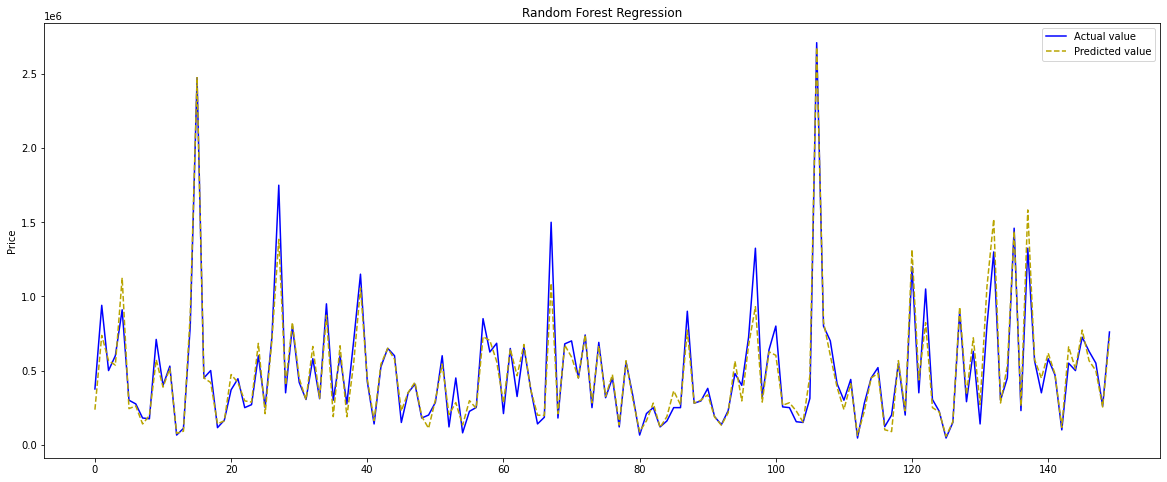

In [108]:
plot_results_graph('Random Forest Regression', y_test, y_pred, 1250, 1400)

### Let's see if we can improve the model using GridSearchCV

In [109]:
from sklearn.model_selection import GridSearchCV

# 11 features = no brand categorical features
params = [
    { "bootstrap": [True, False], 'n_estimators': [10, 50, 100, 200, 300], 'max_features': [11, 41] }
]

forest_reg = RandomForestRegressor(random_state=73)

grid_search = GridSearchCV(forest_reg, params, cv=5, scoring='r2', return_train_score=True, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...bootstrap=True, max_features=11, n_estimators=10; total time=   0.0s
[CV] END ...bootstrap=True, max_features=11, n_estimators=10; total time=   0.0s
[CV] END ...bootstrap=True, max_features=11, n_estimators=10; total time=   0.0s
[CV] END ...bootstrap=True, max_features=11, n_estimators=10; total time=   0.0s
[CV] END ...bootstrap=True, max_features=11, n_estimators=10; total time=   0.0s
[CV] END ...bootstrap=True, max_features=11, n_estimators=50; total time=   0.2s
[CV] END ...bootstrap=True, max_features=11, n_estimators=50; total time=   0.2s
[CV] END ...bootstrap=True, max_features=11, n_estimators=50; total time=   0.2s
[CV] END ...bootstrap=True, max_features=11, n_estimators=50; total time=   0.2s
[CV] END ...bootstrap=True, max_features=11, n_estimators=50; total time=   0.2s
[CV] END ..bootstrap=True, max_features=11, n_estimators=100; total time=   0.5s
[CV] END ..bootstrap=True, max_features=11, n_e

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=73),
             param_grid=[{'bootstrap': [True, False], 'max_features': [11, 41],
                          'n_estimators': [10, 50, 100, 200, 300]}],
             return_train_score=True, scoring='r2', verbose=2)

In [110]:
print("Best params:", grid_search.best_params_)
print("Best estimator:", grid_search.best_estimator_)

Best params: {'bootstrap': False, 'max_features': 11, 'n_estimators': 200}
Best estimator: RandomForestRegressor(bootstrap=False, max_features=11, n_estimators=200,
                      random_state=73)


Quite surprised that the model performs better with fewer features. Let's test this and compare the results.

In [111]:
y_pred = grid_search.predict(X_test)

np.set_printoptions(precision=2)
actual_vs_pred = np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1)

print(["Actual", "Predictions"])
print(actual_vs_pred[:8])

['Actual', 'Predictions']
[[3400000.   3400000.  ]
 [ 950000.   1105587.39]
 [ 934000.    770775.  ]
 [ 450000.    450250.  ]
 [ 350000.    389600.  ]
 [ 140000.    178042.5 ]
 [1125000.   1125000.  ]
 [ 316000.    268000.  ]]


In [112]:
grid_search_result = model_evaluation('Random Forest Grid Search', grid_search.best_estimator_, y_test, y_pred)

for i in range(len(grid_search_result)):
    print(labels[i], ':', grid_search_result[i])

Model : Random Forest Grid Search
R2 : 0.971368766894815
MAE : 57339.50073229031
RMSE : 100471.28850407233
R2 CV Mean : 0.9570480475643819


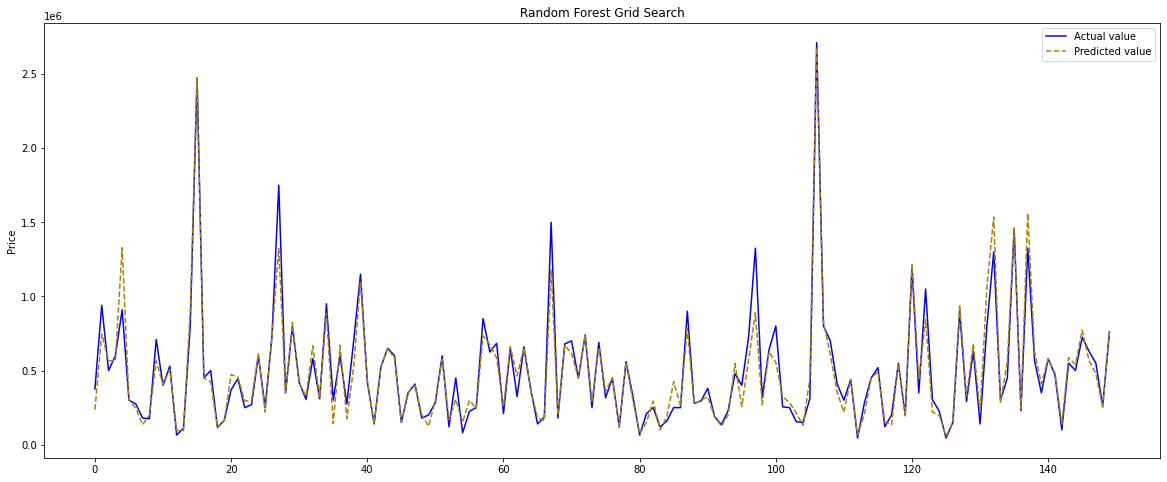

In [113]:
plot_results_graph('Random Forest Grid Search', y_test, y_pred, 1250, 1400)

Surprisingly, the model performs slightly better with fewer features than the Random Forest Model with all features. Let's see if can improve the model further using randomized search.

### Randomized Search

In [114]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

params_distribs = { 
    'n_estimators': randint(low=50, high=400),
    'max_features': randint(low=6, high=12) 
}

forest_reg = RandomForestRegressor(random_state=73)

rnd_search = RandomizedSearchCV(forest_reg, params_distribs, cv=5, scoring='r2', n_iter=10, return_train_score=True, verbose=2, random_state=73)
rnd_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................max_features=8, n_estimators=322; total time=   1.6s
[CV] END ...................max_features=8, n_estimators=322; total time=   1.6s
[CV] END ...................max_features=8, n_estimators=322; total time=   1.7s
[CV] END ...................max_features=8, n_estimators=322; total time=   1.6s
[CV] END ...................max_features=8, n_estimators=322; total time=   1.6s
[CV] END ...................max_features=6, n_estimators=373; total time=   1.7s
[CV] END ...................max_features=6, n_estimators=373; total time=   1.7s
[CV] END ...................max_features=6, n_estimators=373; total time=   1.7s
[CV] END ...................max_features=6, n_estimators=373; total time=   1.8s
[CV] END ...................max_features=6, n_estimators=373; total time=   1.7s
[CV] END ...................max_features=7, n_estimators=216; total time=   1.0s
[CV] END ...................max_features=7, n_es

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=73),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A9B22BE940>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001A9B22BE730>},
                   random_state=73, return_train_score=True, scoring='r2',
                   verbose=2)

In [115]:
print("Best params:", rnd_search.best_params_)
print("Best estimator:", rnd_search.best_estimator_)

Best params: {'max_features': 7, 'n_estimators': 216}
Best estimator: RandomForestRegressor(max_features=7, n_estimators=216, random_state=73)


In [116]:
y_pred = rnd_search.predict(X_test)

np.set_printoptions(precision=2)
actual_vs_pred = np.concatenate((y_test.reshape(len(y_test), 1), y_pred.reshape(len(y_pred), 1)), 1)

print(["Actual", "Predictions"])
print(actual_vs_pred[:8])

['Actual', 'Predictions']
[[3400000.   3375495.36]
 [ 950000.   1081401.11]
 [ 934000.    748419.37]
 [ 450000.    417733.8 ]
 [ 350000.    408402.77]
 [ 140000.    174870.34]
 [1125000.   1099185.17]
 [ 316000.    279066.01]]


In [117]:
rnd_search_result = model_evaluation('Random Forest Randomized Search', rnd_search.best_estimator_, y_test, y_pred)

for i in range(len(rnd_search_result)):
    print(labels[i], ':', rnd_search_result[i])

Model : Random Forest Randomized Search
R2 : 0.9687568305416948
MAE : 60636.494604181455
RMSE : 104954.11906220739
R2 CV Mean : 0.9547047810549726


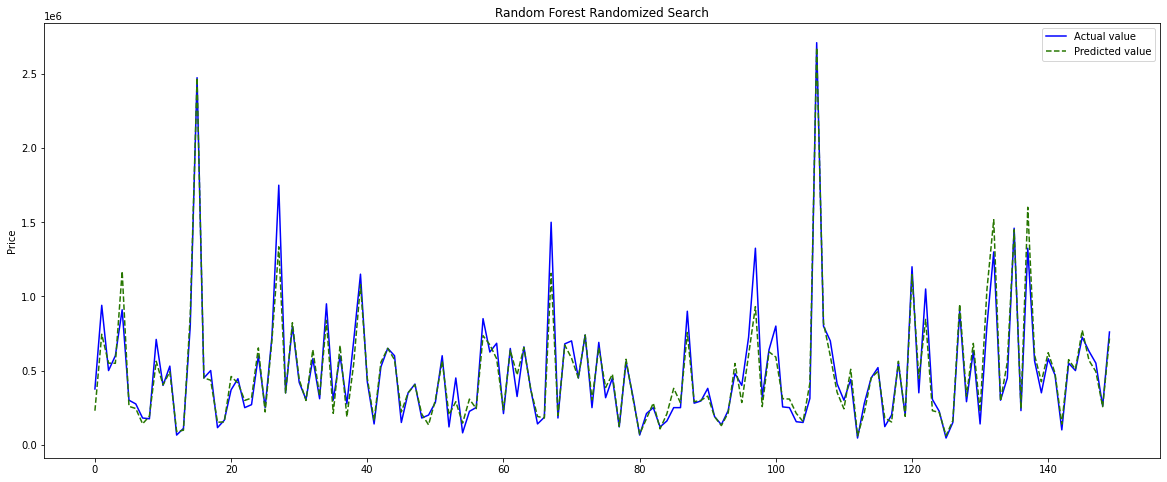

In [118]:
plot_results_graph('Random Forest Randomized Search', y_test, y_pred, 1250, 1400)

### Final model validation

In [119]:
for result in results:
    for i in range(len(result)):
        print(labels[i], ':', result[i])
    print()

Model : Random Forest Regression
R2 : 0.968150075757641
MAE : 62365.82973007254
RMSE : 105968.34395664117
R2 CV Mean : 0.9516562727645939

Model : Random Forest Grid Search
R2 : 0.971368766894815
MAE : 57339.50073229031
RMSE : 100471.28850407233
R2 CV Mean : 0.9570480475643819

Model : Random Forest Randomized Search
R2 : 0.9687568305416948
MAE : 60636.494604181455
RMSE : 104954.11906220739
R2 CV Mean : 0.9547047810549726



In [121]:
best_r2 = None
best_mae = None
best_rmse = None
best_cv_r2 = None

for result in results:
    if best_r2 is None or best_mae is None or best_rmse is None or best_cv_r2 is None:
        best_r2 = result
        best_mae = result
        best_rmse = result
        best_cv_r2 = result

    if result[1] > best_r2[1]:
        best_r2 = result

    if result[2] < best_mae[2]:
        best_mae = result
    
    if result[3] < best_rmse[3]:
        best_rmse = result

    if result[4] > best_cv_r2[4]:
        best_cv_r2 = result

print("Best R2:", best_r2[0], ':', round(best_r2[1], 3))
print("Best MAE:", best_mae[0], ':', round(best_mae[2], 3))
print("Best RMSE:", best_rmse[0], ':', round(best_rmse[3], 3))
print("Best CV R2", best_cv_r2[0], ':', round(best_cv_r2[4], 3))

Best R2: Random Forest Grid Search : 0.971
Best MAE: Random Forest Grid Search : 57339.501
Best RMSE: Random Forest Grid Search : 100471.289
Best CV R2 Random Forest Grid Search : 0.957


It seems the best model is the Random Forest Model that was found using GridSearchCV. I think this is as good as it gets. Being able to predict a used cars price with a deviation of less than 5% is a great accomplishment. Let's try to test some real world data and visualize the results.

## Trying real world data

In [153]:
# Real world data taken from https://www.cardekho.com/buy-used-car-details/used-Hyundai-I20-Sportz-cars-Noida_90dc4a30-798c-45f9-a494-1e5c0c853d71.htm

forest_reg = grid_search.best_estimator_
forest_reg.predict([[2017, 36375, 1, 0, 1, 0, 5, 21, 1200, 82, 115, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([565888.32])

The predicted resulted in ₹ 565.888. And the actual price was ₹ 562.000. That is a really good result. The result was only off by ₹ 5.888. Which in DKK totals to 517,27 DKK. For a car that amount is next to nothing, so I think this is a really good result.